In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore') # tsne fica mandando avisos chatos
# from sklearn.utils import check_random_state

In [3]:
from sklearn import __version__ as versaosk
versaosk

'1.0.2'

# LeafEmbedding

## High level de CART (Classification And Regression Trees)


```

Algorithm: DecisionTreeTrain(data)

guess ← most frequent answer in data // default answer for this data
if the labels in data are unambiguous then
    return Leaf(guess) // no need to split further
else 
    for f in features:
        for split in splits_of_f:
             score_of_split[f, split] ← criterion(data, split, f)

f, split ← the feature with best score_of_split(f, split)

left_data ← the subset of data on which f<=split
right_data ← the subset of data on which f>split
left ← DecisionTreeTrain(left_data)
right ← DecisionTreeTrain(right_data)

return Node(f, split, left, right)

```
Adaptado de [CIML](http://ciml.info/dl/v0_99/ciml-v0_99-ch01.pdf) do Hal Daumé III. Aqui o único critério de parada é termos folhas puras.

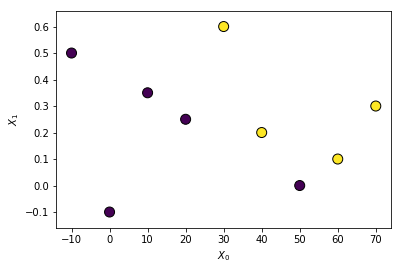

In [4]:
X_dt = np.array([[0,-0.1], [10,0.35], [-10, 0.5], [20, 0.25], [50, 0], [40, 0.2], [60, 0.1],[30, 0.6], [70, 0.3]])
y_dt = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1])

plt.scatter(X_dt[:,0],X_dt[:,1], c=y_dt, edgecolors='k', s=100)
plt.xlabel('$X_0$')
plt.ylabel('$X_1$')
plt.show()

In [5]:
sorted(X_dt[:,0])

[-10.0, 0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0]

In [6]:
valores_intermediarios_X0 = [(xi+xi1)/2 for xi, xi1 in zip(sorted(X_dt[:,0])[:-1], sorted(X_dt[:,0])[1:])]
valores_intermediarios_X0

[-5.0, 5.0, 15.0, 25.0, 35.0, 45.0, 55.0, 65.0]

In [7]:
valores_intermediarios_X1 = [(xi+xi1)/2 for xi, xi1 in zip(sorted(X_dt[:,1])[:-1], sorted(X_dt[:,1])[1:])]

# se tivesse valores repitidos na nossa feature Xi, poderíamos ter dado um "sorted(set(X_dt[:,i]))"

Um critério para avaliar splits no contexto de classificação é a [impureza de Gini](https://www.learndatasci.com/glossary/gini-impurity/).

Considere um conjunto de dados $D$ com $k$ classes. A proporção de exemplos que pertencem à classe $i$ dentro do conjunto $D$ é denotado por $p_i$. A impureza de Gini do conjunto $D$ é definida como:

$$\textrm{Gini}(D) = 1 - \sum_{i=1}^k p_i^{\,2}\,.$$

Se um conjunto de dados $D$ de tamanho $n$ é quebrado no atributo $f$, no split $s$, gerando dois subconjuntos $L=D[f\leq s]$ e $R=D[f>s]$ com tamanhos, $n_L$ e $n_R$, respectivamente, a impureza de Gini da minha quebra é definida como:

$$ \textrm{Gini}(D, f, s) = \frac{n_L}{n} \textrm{Gini}(L) + \frac{n_R}{n} \textrm{Gini}(R) \,.$$

In [8]:
def gini(y):
    return 1 - (y.mean())**2 - (1-y.mean())**2
    
def gini_of_split(split, y, Xi):
    
    y_left = y[Xi<=split]
    y_right = y[Xi>split]
    
    return y_left.shape[0]/y.shape[0]*gini(y_left) + y_right.shape[0]/y.shape[0]*gini(y_right)

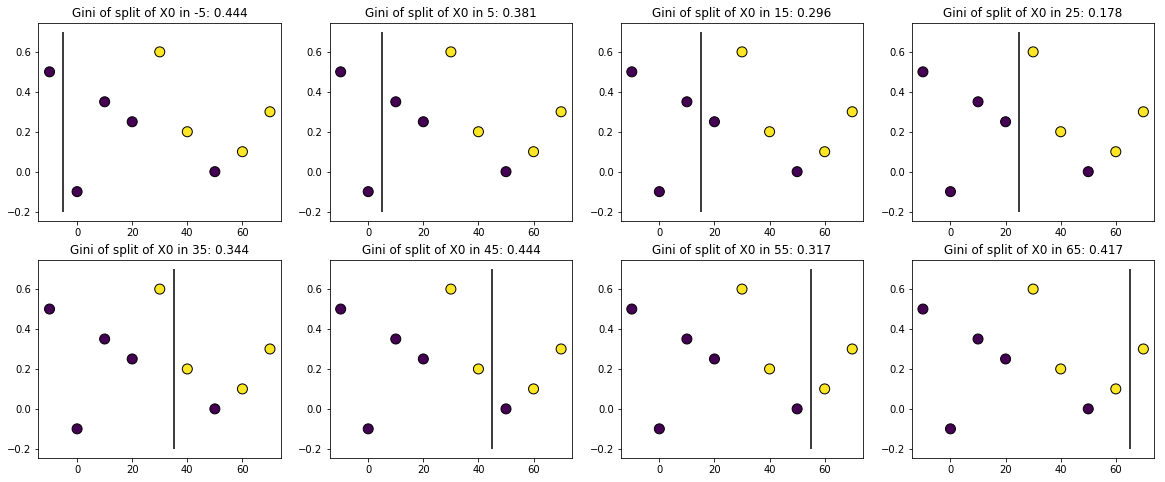

In [9]:
fig, axis = plt.subplots(nrows=2, ncols=4, figsize=(20,8))
for i, split in enumerate(valores_intermediarios_X0):
    axis[(int(i/4),i%4)].scatter(X_dt[:,0],X_dt[:,1], c=y_dt, edgecolors='k', s=100)
    axis[(int(i/4),i%4)].vlines(split, -0.2, 0.7)
    axis[(int(i/4),i%4)].set_title('Gini of split of X0 in '+str(int(split))+': '+str(np.round(gini_of_split(split, y_dt, X_dt[:,0]),3)))
plt.show()

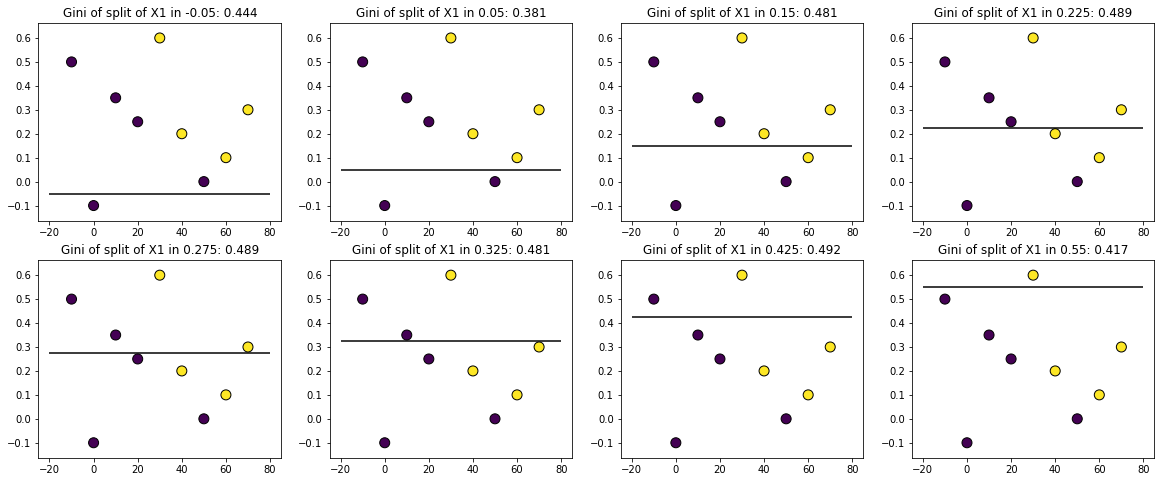

In [10]:
fig, axis = plt.subplots(nrows=2, ncols=4, figsize=(20,8))
for i, split in enumerate(valores_intermediarios_X1):
    axis[(int(i/4),i%4)].scatter(X_dt[:,0],X_dt[:,1], c=y_dt, edgecolors='k', s=100)
    axis[(int(i/4),i%4)].hlines(split, -20, 80)
    axis[(int(i/4),i%4)].set_title('Gini of split of X1 in '+str(np.round(split,3))+': '+str(np.round(gini_of_split(split, y_dt, X_dt[:,1]),3)))
plt.show()

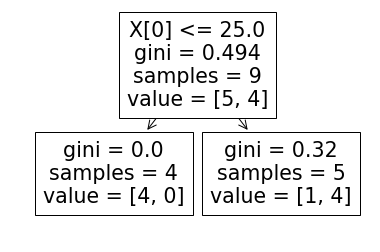

In [11]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

plot_tree(DecisionTreeClassifier(max_depth=1, criterion='gini').fit(X_dt,y_dt))
plt.show()

In [12]:
np.round(gini(y_dt),3)

0.494

In [13]:
np.round(4/9* 0 + 5/9*0.32,3)

0.178

No problema de regressão a ideia é similar: avaliamos o split olhando como fica o MSE (ou MAE, por exemplo) daquela quebra.

### Takeaways

- Árvores costumam aprender bem quais são as features importantes pelo processo de escolha do melhor split.
- Árvores não se preocupam com escala das variáveis uma vez que, no treinamento, ela se preocupa apenas com a ordenação deles.

## High level of Bagging (Bootstrap aggregation) de árvores

Uma árvore somente não faz um trabalho muito bom sozinha. Se ela for profunda demais, ela tem tendência a overfitting (decora os dados de treino) e se ela for rasa demais, temos um modelo muito simples. 

Combinar várias árvores diferentes (rigorosamente, diferentes deveria significar "independentes" probabilisticamente falando) ajuda a reduzir a variância (isso não nos interessa agora, mas para mais informações dê uma olhada na seção 8.2 do [ISL](https://www.ime.unicamp.br/~dias/Intoduction%20to%20Statistical%20Learning.pdf)). Como tentar deixar as árvores **independentes**? A ideia é reamostrar (com repetição) o conjunto de treino várias vezes para gerar versões diferentes dele mesmo.

Cada uma das árvores é criada com um conjunto um pouco diferente (mas que idealmente tem a mesma distribuição do conjunto original) e, possivelmente usando features diferentes (`max_features`).

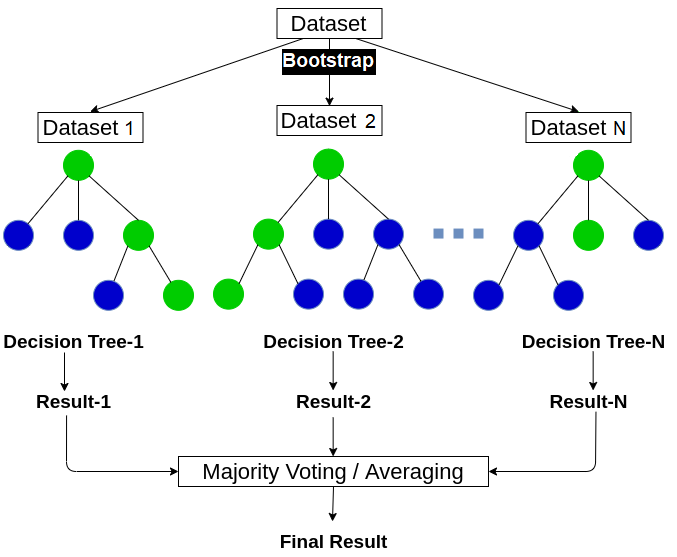

As [Extra Randomized Trees](https://www.researchgate.net/publication/220343368_Extremely_Randomized_Trees) são muito parecidas com as Random Forests, mas elas tem mais um fator de aleatorização. Quando procuram o melhor split em um determinado nó, elas não olham todos os splits possíveis de todas as features. Elas olham pra splits random de cada uma dessas features.

```
Pick a random split(S,a)
Inputs: a subset S and an attribute a
Output: a split

– Let aS_max and aS_min denote the maximal and minimal value of a in S;
– Draw a random cut-point ac uniformly in [aS_min, aS_max];
– Return the split [a < ac].
```

É mais aceitável no Extra Randomized Trees você não fazer bootstrap já que você tá criando uma independência mais forçada nos splits.

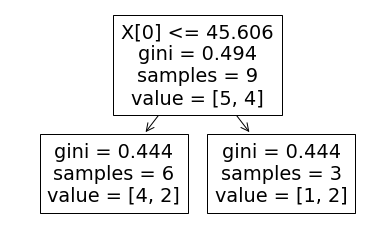

In [14]:
from sklearn.tree import ExtraTreeClassifier

# ExtraTreeClassifier \neq ExtraTreesClassifier

plot_tree(ExtraTreeClassifier(random_state=3, max_depth=1, criterion='gini').fit(X_dt,y_dt))
plt.show()

Pode parecer estranho isso, mas a ideia aqui é ter árvores realmente independentes uma da outra. Se todas as árvores são iguais, de que adianta fazer essa quebra com votação? No final, a ideia é que a média nos dê um resultado legal.

.

## Ideia do LeafEmbedding

**Conseguimos calcular uma similaridade entre exemplos calculando o número de vezes que eles coincidem nas folhas de uma floresta de árvores!**

```
- We do not need to worry about the scaling of the features, as we’re using decision trees. Also, as we’re using leaf co-ocurrence as our similarity, we do not need to be concerned that distance is not defined for categorical variables.

- For supervised embeddings, we automatically set optimal weights for each feature for clustering.
```
Adaptado do post [Supervised clustering and forest embeddings](https://gdmarmerola.github.io/forest-embeddings/) do Guilherme Duarte (DS Manager da Loft).

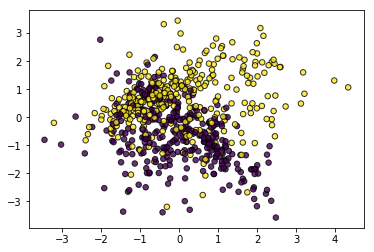

In [15]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=1000, n_features=25, n_informative=2, n_redundant=2, 
                           flip_y=0.1, class_sep=0.7, n_clusters_per_class=2,
                           shuffle=False, random_state=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.33, random_state=1)

plt.scatter(X_train[:,0], X_train[:,1], s=30, c=y_train, edgecolors='k', alpha=0.8)
plt.show()

In [16]:
pd.DataFrame(X_train).describe()#.loc['std']

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
count,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000
mean,-0.005677,0.000133,0.004031,0.004958,0.014914,-0.032982,0.041844,-0.021279,-0.011244,0.017560,0.013178,-0.017693,-0.021558,-0.006938,0.061925,-0.009066,0.029370,0.060659,0.007819,0.015425,0.042449,0.023686,-0.046341,-0.019323,0.109458
std,1.146454,1.218227,0.823168,1.383693,1.007717,1.008263,0.961342,1.007579,0.985123,0.984288,0.982138,0.975139,0.981136,0.926069,1.023827,1.013246,1.047910,0.997286,0.969970,1.015937,0.996189,1.033086,0.996165,1.024358,0.995879
min,-3.461544,-3.574632,-2.980338,-4.855266,-3.282079,-2.886694,-2.984836,-3.038443,-2.484895,-2.967467,-2.984240,-2.932255,-2.872050,-3.119119,-3.435926,-3.259206,-3.219132,-3.029344,-2.879233,-3.927514,-2.993491,-3.090503,-2.868046,-2.925305,-3.294858
25%,-0.846809,-0.862375,-0.597413,-0.926644,-0.670255,-0.720222,-0.662066,-0.698469,-0.747666,-0.646244,-0.620378,-0.680423,-0.678247,-0.629249,-0.588803,-0.651220,-0.659144,-0.641427,-0.673227,-0.692791,-0.603559,-0.679838,-0.719895,-0.649708,-0.508890
50%,-0.135328,0.069298,0.105756,0.259604,0.041872,-0.025605,0.102501,-0.048043,-0.002820,0.041421,-0.010105,0.012048,-0.054977,-0.018175,0.118760,0.011251,-0.029649,0.030443,0.041283,0.012370,0.075492,0.026392,-0.053456,-0.059807,0.108435
75%,0.809223,0.819865,0.613401,1.088902,0.699995,0.626778,0.688434,0.636126,0.694786,0.665588,0.707063,0.650252,0.646099,0.645023,0.763567,0.637144,0.770178,0.738984,0.694295,0.710764,0.668797,0.733141,0.602691,0.649222,0.730781
max,4.336961,3.447581,2.382856,3.852898,3.560873,2.847782,2.991107,3.560613,2.776354,3.740249,3.227936,3.118480,3.079608,2.533344,4.026849,3.446956,3.135047,2.798819,2.572471,3.613277,2.706125,3.834381,3.391943,3.111892,2.763729


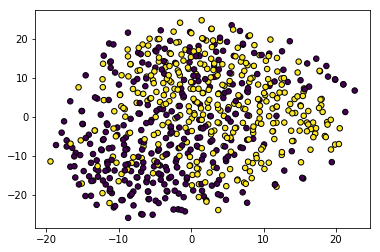

In [17]:
# StatQuest: t-SNE, Clearly Explained https://youtu.be/NEaUSP4YerM
from sklearn.manifold import TSNE

# x = StandardScaler().fit_transform(X_train)
tsne = TSNE(random_state=1, metric='euclidean').fit(X_train)
tsne_emb = tsne.embedding_
plt.scatter(tsne_emb[:,0], tsne_emb[:,1], s=30, c=y_train, edgecolors='k')
plt.show()

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score

rfc = RandomForestClassifier(random_state=1, max_depth=3).fit(X_train, y_train)
roc_auc_score(y_test, rfc.predict_proba(X_test)[:,1]), average_precision_score(y_test, rfc.predict_proba(X_test)[:,1])

(0.7999338624338624, 0.7563555570525866)

In [19]:
(pd.DataFrame(list(zip(['col_'+str(t) for t in range(20)], 
                       rfc.feature_importances_)), 
              columns=['feat', 'feat_imp'])
 .sort_values(by='feat_imp', ascending=False)
 .head(10)
 .T
)

,1,3,2,0,13,8,18,16,10,19
feat,col_1,col_3,col_2,col_0,col_13,col_8,col_18,col_16,col_10,col_19
feat_imp,0.390457,0.229597,0.0411929,0.0394652,0.0322264,0.0221342,0.0214275,0.0207182,0.0174948,0.0169988


In [20]:
rfc

RandomForestClassifier(max_depth=3, random_state=1)

In [21]:
type(rfc.estimators_)

list

In [22]:
rfc.estimators_[0]

DecisionTreeClassifier(max_depth=3, max_features='auto',
                       random_state=1791095845)

In [23]:
from sklearn.utils.validation import check_is_fitted

check_is_fitted(rfc.estimators_[0])

In [24]:
# not_fitted_model = RandomForestClassifier()
# check_is_fitted(not_fitted_model)

In [25]:
# rfc.estimators_[0].predict_proba(X_test)[:,1]

In [26]:
# rfc.estimators_[0].apply(X_test)

In [27]:
rfc.estimators_[0].apply(X_test[0].reshape(1,-1))

array([11], dtype=int64)

In [28]:
# rfc.estimators_[0].apply(X_test)

In [29]:
np.array([arvore.apply(X_test) for arvore in rfc.estimators_]).T

array([[11,  6, 10, ...,  6,  3,  3],
       [ 8,  4, 14, ...,  6,  4,  3],
       [12, 10, 14, ...,  7,  4,  6],
       ...,
       [12, 10, 14, ..., 10,  4,  6],
       [ 8,  4, 14, ...,  6,  4,  7],
       [ 8,  4, 10, ...,  6,  3,  3]], dtype=int64)

In [30]:
leaf = rfc.apply(X_test)
leaf

array([[11,  6, 10, ...,  6,  3,  3],
       [ 8,  4, 14, ...,  6,  4,  3],
       [12, 10, 14, ...,  7,  4,  6],
       ...,
       [12, 10, 14, ..., 10,  4,  6],
       [ 8,  4, 14, ...,  6,  4,  7],
       [ 8,  4, 10, ...,  6,  3,  3]], dtype=int64)

In [31]:
leaf[0]

array([11,  6, 10, 10,  4,  3,  7,  4,  6,  6,  4,  4,  3,  6,  6,  3,  3,
        4,  3,  3,  4, 11, 10,  3,  3,  3, 10, 11, 10, 11,  7,  3,  3,  3,
        6,  3, 11, 11, 11,  6,  4, 11,  4, 11,  6,  4,  4,  6,  6,  3,  3,
        8,  3,  3,  3,  3,  7,  3,  4, 10, 10,  3,  3,  6,  3,  3,  6, 10,
       13,  3,  4,  7,  3, 10,  4,  3,  4,  7,  7,  3,  3,  4,  3,  6,  3,
       13,  3,  3,  5,  6,  8,  6,  3,  4, 14,  4,  7,  6,  3,  3],
      dtype=int64)

In [32]:
leaf[1]

array([ 8,  4, 14,  4,  7,  4, 11,  7, 10,  6, 14,  3,  7,  4,  4,  3, 10,
        4, 14,  3,  7, 14, 13,  4,  6,  7, 11, 11,  7,  7,  3,  3, 10,  4,
       11,  4,  6,  6, 11, 13, 10,  4, 14, 13, 11,  4,  7,  7, 14,  8,  4,
        9,  3,  7, 11,  7, 10, 10,  7, 14,  4, 11, 10,  7,  4, 10, 11,  6,
        7,  4,  4, 13, 11, 11, 13,  6,  4,  6,  7,  6, 10,  4,  3,  7,  3,
        7,  4,  7,  4,  6, 11, 14,  4, 10, 13, 11, 10,  6,  4,  3],
      dtype=int64)

In [33]:
(leaf[0]==leaf[1]).mean()

0.18

In [34]:
from scipy.spatial.distance import cdist
# https://pt.wikipedia.org/wiki/Dist%C3%A2ncia_de_Hamming

cdist(leaf, leaf, 'hamming')

array([[0.  , 0.82, 0.93, ..., 0.94, 0.85, 0.43],
       [0.82, 0.  , 0.7 , ..., 0.82, 0.46, 0.71],
       [0.93, 0.7 , 0.  , ..., 0.48, 0.59, 0.9 ],
       ...,
       [0.94, 0.82, 0.48, ..., 0.  , 0.74, 0.94],
       [0.85, 0.46, 0.59, ..., 0.74, 0.  , 0.78],
       [0.43, 0.71, 0.9 , ..., 0.94, 0.78, 0.  ]])

In [35]:
from sklearn.preprocessing import OneHotEncoder

leaf_ohe = OneHotEncoder().fit_transform(leaf)
leaf_ohe

<330x732 sparse matrix of type '<class 'numpy.float64'>'
	with 33000 stored elements in Compressed Sparse Row format>

In [36]:
leaf_ohe.sum()/(leaf_ohe.shape[0]*leaf_ohe.shape[1])

0.1366120218579235

In [37]:
leaf_ohe.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [38]:
# leaf_ohe.toarray()[0]

In [39]:
cdist(leaf, leaf, 'hamming')

array([[0.  , 0.82, 0.93, ..., 0.94, 0.85, 0.43],
       [0.82, 0.  , 0.7 , ..., 0.82, 0.46, 0.71],
       [0.93, 0.7 , 0.  , ..., 0.48, 0.59, 0.9 ],
       ...,
       [0.94, 0.82, 0.48, ..., 0.  , 0.74, 0.94],
       [0.85, 0.46, 0.59, ..., 0.74, 0.  , 0.78],
       [0.43, 0.71, 0.9 , ..., 0.94, 0.78, 0.  ]])

In [40]:
np.round(cdist(leaf_ohe.toarray(), leaf_ohe.toarray(), 'hamming'),4)

array([[0.    , 0.224 , 0.2541, ..., 0.2568, 0.2322, 0.1175],
       [0.224 , 0.    , 0.1913, ..., 0.224 , 0.1257, 0.194 ],
       [0.2541, 0.1913, 0.    , ..., 0.1311, 0.1612, 0.2459],
       ...,
       [0.2568, 0.224 , 0.1311, ..., 0.    , 0.2022, 0.2568],
       [0.2322, 0.1257, 0.1612, ..., 0.2022, 0.    , 0.2131],
       [0.1175, 0.194 , 0.2459, ..., 0.2568, 0.2131, 0.    ]])

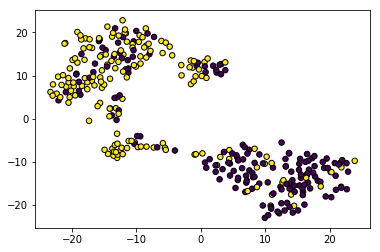

In [41]:
tsne = TSNE(random_state=1, metric='hamming').fit(leaf)
tsne_emb = tsne.embedding_
plt.scatter(tsne_emb[:,0], tsne_emb[:,1], s=30, c=y_test, edgecolors='k')#, cmap='RdBu')
plt.show()

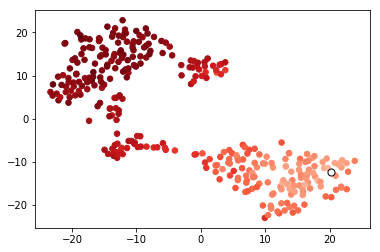

In [42]:
plt.scatter(tsne_emb[:,0], tsne_emb[:,1], s=30, c=cdist(leaf, leaf, 'hamming')[0], cmap='Reds')
plt.scatter(tsne_emb[0,0], tsne_emb[0,1], s=50, c='w', edgecolors='k')
plt.show()

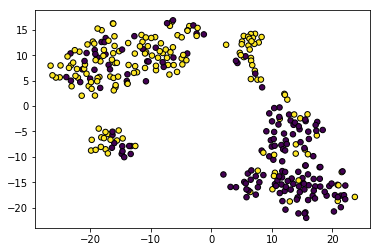

In [43]:
tsne_ohe = TSNE(random_state=1, metric='precomputed').fit(cdist(leaf_ohe.toarray(), leaf_ohe.toarray(), 'hamming'))
tsne_ohe_emb = tsne_ohe.embedding_
plt.scatter(tsne_ohe_emb[:,0], tsne_ohe_emb[:,1], s=30, c=y_test, edgecolors='k')#, cmap='RdBu')
plt.show()

## Não Supervisionado

In [44]:
from sklearn.ensemble import RandomTreesEmbedding, ExtraTreesRegressor

In [45]:
# help(ExtraTreeClassifier(max_features=1))

In [46]:
rte = RandomTreesEmbedding(random_state=1, sparse_output=False)
rte.fit(X_train, None)
leaf_nsup = rte.transform(X_test)

Deveria ser equivalente a:

```python
etr = ExtraTreesRegressor(max_features=1, random_state=1, max_depth=5)
etr.fit(X_train, y_train)
leaf_nsup = etr.apply(X_test)
leaf_nsup = OneHotEncoder(sparse=False).fit_transform(leaf_nsup)
```

Na prática, o resultado muda um pouco pelao jeito interno que eles são construídos (random_state é aplicado de forma diferente pelo que entendi).

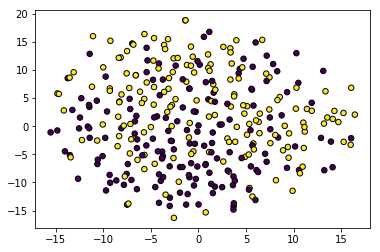

In [47]:
tsne_nsup = TSNE(random_state=1, metric='hamming').fit(leaf_nsup)
tsne_nsup_emb = tsne_nsup.embedding_
plt.scatter(tsne_nsup_emb[:,0], tsne_nsup_emb[:,1], s=30, c=y_test, edgecolors='k')
plt.show()

## Regressão

In [48]:
from sklearn.datasets import make_regression
X_reg, y_reg = make_regression(1000, random_state=1, n_features=50, n_informative=3)

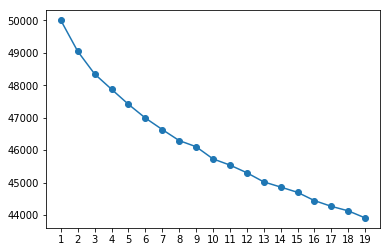

In [49]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

inertia = []
for i in range(1, 20):
    kmeans_reg = Pipeline([('std', StandardScaler()), ('kmeans', KMeans(n_clusters=i, random_state=1))])
    kmeans_reg.fit(X_reg)
    inertia.append(kmeans_reg.named_steps['kmeans'].inertia_)
    
plt.plot(range(1,20), inertia, marker='o')
plt.xticks(range(1,20), range(1,20))
plt.show()

In [50]:
kmeans_reg = (Pipeline([('std', StandardScaler()), 
                        ('kmeans', KMeans(n_clusters=3, random_state=1))])
              .fit(X_reg)
             )

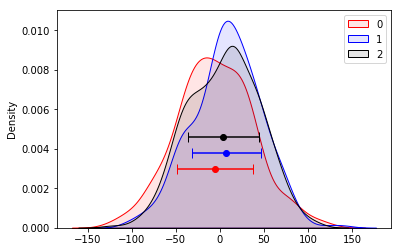

In [51]:
from itertools import cycle
for i, c in zip(range(kmeans_reg.named_steps['kmeans'].n_clusters), cycle('rbkgym')):
    sns.kdeplot(y_reg[kmeans_reg.predict(X_reg)==i], alpha=0.1, shade=True, color=c, label=i)
    plt.errorbar(y_reg[kmeans_reg.predict(X_reg)==i].mean(), 3e-3+i*8e-4, xerr=y_reg[kmeans_reg.predict(X_reg)==i].std()
             , color=c, marker='o', capsize=5)
plt.legend()
plt.show()

In [52]:
pd.DataFrame([y_reg,kmeans_reg.predict(X_reg)], index=['y', 'cluster']).T.groupby('cluster').agg([np.mean, np.std, 'count'])

y                 
             mean        std count
cluster                           
0.0     -5.613057  43.563641   340
1.0      7.377015  39.370331   354
2.0      4.029419  40.257213   306

In [53]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

rfr = RandomForestRegressor(max_depth=4, n_estimators=100).fit(X_reg, y_reg)
r2_score(y_reg, rfr.predict(X_reg))

0.9179283358683133

In [54]:
reg_leaf = rfr.apply(X_reg)

In [55]:
from sklearn.cluster import AgglomerativeClustering

ac = AgglomerativeClustering(n_clusters=3, affinity='hamming', linkage='average').fit(reg_leaf)

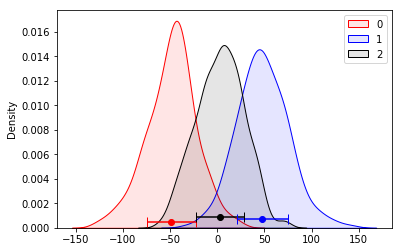

In [56]:
for i, c in zip(range(ac.n_clusters_), cycle('rbkgym')):
    sns.kdeplot(y_reg[ac.labels_==i], alpha=0.1, shade=True, color=c, label=i)
    plt.errorbar(y_reg[ac.labels_==i].mean(), 5e-4+i*2e-4, xerr=y_reg[ac.labels_==i].std()
             , color=c, marker='o', capsize=5)
plt.legend()
plt.show()

In [57]:
pd.DataFrame([y_reg,ac.labels_], index=['y', 'cluster']).T.groupby('cluster').agg([np.mean, np.std, 'count'])

y                 
              mean        std count
cluster                            
0.0     -48.665318  26.253559   219
1.0      47.855330  27.387774   230
2.0       2.880226  25.145453   551

In [58]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.3, min_samples=5, metric='hamming')
cluster_dbscan = dbscan.fit_predict(reg_leaf)
np.unique(cluster_dbscan)

array([-1,  0,  1,  2,  3], dtype=int64)

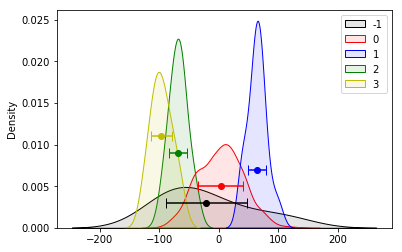

In [59]:
for i, c in zip(np.unique(cluster_dbscan), cycle('krbgym')):
    sns.kdeplot(y_reg[cluster_dbscan==i], alpha=0.1, shade=True, color=c, label=i)
    plt.errorbar(y_reg[cluster_dbscan==i].mean(), 5e-3+i*2e-3, xerr=y_reg[cluster_dbscan==i].std()
             , color=c, marker='o', capsize=5)
plt.legend()
plt.show()


In [60]:
pd.DataFrame([y_reg,cluster_dbscan], index=['y', 'cluster']).T.groupby('cluster').agg([np.mean, np.std, 'count'])

y                 
              mean        std count
cluster                            
-1.0    -20.929752  75.160233     6
 0.0      2.944678  38.179242   946
 1.0     63.884954  15.948932    23
 2.0    -68.534813  15.407432     8
 3.0    -96.772733  18.170428    17

## Porque não só agrupar no predict/predict_proba?

In [61]:
n_ = 3000
y_uni = np.random.RandomState(0).binomial(1, 0.5, n_)
X_uni = np.vstack([0.25*y_uni + np.random.RandomState(1).uniform(0,1, n_), 
                   0.25*y_uni + np.random.RandomState(2).uniform(-0,1, n_)]).T

In [62]:
X_train_uni, X_test_uni, y_train_uni, y_test_uni = train_test_split(X_uni, y_uni, shuffle=True, random_state=1)

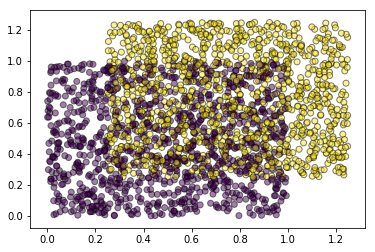

In [63]:
plt.scatter(X_train_uni[:,0], X_train_uni[:,1], c=y_train_uni, alpha=0.5, edgecolors='k')
plt.show()

In [64]:
def cores(X):
    condlist = [(X[:,0]>1) & (X[:,1]>1),        (X[:,0]>1) & (X[:,1]<=1), 
                (X[:,0]<=1) & (X[:,1]>1),       (X[:,0]<0.25) & (X[:,1]<0.25), 
                (X[:,0]<0.25) & (X[:,1]>=0.25), (X[:,0]>=0.25) & (X[:,1]<0.25)]
    choicelist = list('krbgym')
    return np.select(condlist, choicelist, 'w')

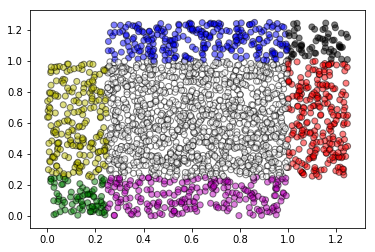

In [65]:
plt.scatter(X_train_uni[:,0], X_train_uni[:,1], c=cores(X_train_uni), alpha=0.5, edgecolors='k')
plt.show()

In [66]:
rfc_uni = RandomForestClassifier(random_state=1, max_depth=5).fit(X_train_uni, y_train_uni)
roc_auc_score(y_test_uni, rfc_uni.predict_proba(X_test_uni)[:,1])

0.8376099785216318

In [67]:
leaf_uni = rfc_uni.apply(X_test_uni)

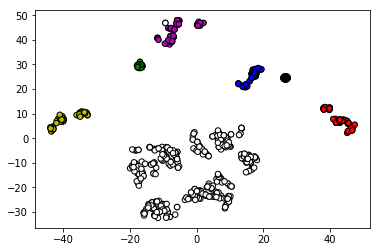

In [68]:
tsne_uni = TSNE(random_state=1, metric='hamming').fit(leaf_uni)
tsne_uni_emb = tsne_uni.embedding_
plt.scatter(tsne_uni_emb[:,0], tsne_uni_emb[:,1], s=30, c=cores(X_test_uni), edgecolors='k')#, cmap='RdBu')
plt.show()

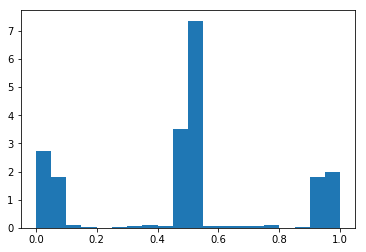

In [69]:
plt.hist(rfc_uni.predict_proba(X_test_uni)[:,1], bins=20, density=True)
plt.show()

In [70]:
def cores_predict(y_pred):
    condlist = [y_pred<0.25, (y_pred>=0.25) & (y_pred<=0.75), y_pred>0.75]
    choicelist = list('rwb')
    return np.select(condlist, choicelist, 'k')

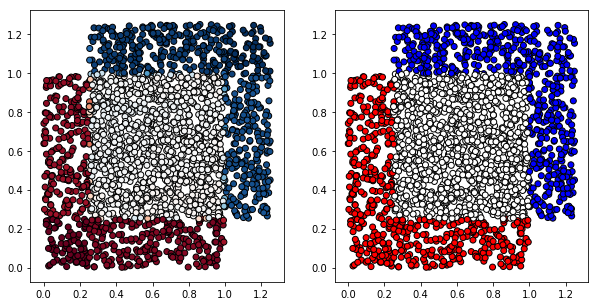

In [71]:
fig, axis = plt.subplots(ncols=2, figsize=(10,5))
axis[0].scatter(X_train_uni[:,0], X_train_uni[:,1], 
                c=rfc_uni.predict_proba(X_train_uni)[:,1],  edgecolors='k', cmap='RdBu')
axis[1].scatter(X_train_uni[:,0], X_train_uni[:,1], 
                c=cores_predict(rfc_uni.predict_proba(X_train_uni)[:,1]), edgecolors='k')
plt.show()

## Achando vizinhos

In [72]:
from sklearn.neighbors import NearestNeighbors

In [73]:
nn = NearestNeighbors(metric='hamming')
nn.fit(reg_leaf)
dist, neig = nn.kneighbors(reg_leaf, n_neighbors=5)

In [74]:
neig

array([[  0, 704, 237, 602, 589],
       [  1, 832, 839,  54, 601],
       [  2, 424,  85, 349, 495],
       ...,
       [997, 825, 706, 408, 599],
       [998, 508, 162, 490, 193],
       [999, 390, 364, 350, 331]], dtype=int64)

In [75]:
dist

array([[0.  , 0.04, 0.09, 0.12, 0.15],
       [0.  , 0.17, 0.19, 0.19, 0.19],
       [0.  , 0.15, 0.16, 0.18, 0.19],
       ...,
       [0.  , 0.  , 0.03, 0.03, 0.03],
       [0.  , 0.13, 0.19, 0.19, 0.26],
       [0.  , 0.07, 0.12, 0.16, 0.21]])

In [76]:
pd.DataFrame(X_reg[neig[0]])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,1.930981,-1.367805,-0.577265,0.567498,-0.187887,-0.561016,-0.949135,0.826253,-1.670305,1.056050,-3.943142,-2.434379,0.436087,0.677100,0.011913,-2.020238,0.239656,-1.130572,1.380103,0.599125,-1.288466,0.271354,0.487590,-0.124784,-0.502388,-0.668623,-0.109415,-1.075219,0.708643,0.172421,-0.033340,0.279201,-0.013218,1.215526,-0.743037,0.421714,-1.342651,0.509637,-1.111816,0.430953,-0.597019,-0.650113,1.554615,-0.176866,0.092313,0.374207,-0.799400,0.784028,0.313089,-0.775320
1,1.459317,0.647951,-0.023797,0.110321,1.111542,0.860970,0.879585,0.061794,0.229202,-0.318580,1.039690,0.206493,-1.050606,-0.328274,0.060390,-1.071907,-2.620393,-0.453830,-0.604793,-0.072194,-1.128551,-0.088411,0.774659,0.451135,0.253041,0.828148,-1.105534,-0.002292,0.738046,0.434590,-1.536962,0.241143,-0.506249,-0.543710,0.928006,-0.719621,-0.627639,-1.554922,0.666576,-1.264199,1.151369,-0.770291,0.268040,-0.475307,0.081847,1.658882,-0.126627,2.076844,-1.666259,-1.471571
2,-0.990882,0.585663,0.520437,1.878165,-1.119160,-2.369126,-0.377735,-0.019265,-0.937408,-1.347513,0.517550,-1.183652,-0.351387,1.612477,-0.021388,1.477225,0.379763,-0.409162,0.118057,-0.661191,-1.528290,1.468465,-0.051531,0.651156,0.280958,1.023198,-1.211325,-0.384837,-0.700583,-0.423732,-0.428365,0.436648,1.418974,0.213989,-1.737673,-0.051883,-1.007815,-0.215337,0.520461,0.260980,-1.647098,-0.460760,0.394976,1.428573,0.425002,1.132788,-0.340653,-0.073124,-0.372719,-1.539847
3,-1.641879,0.377974,0.585547,-0.979738,0.518639,-1.471333,-0.175053,0.809875,-0.372153,1.963884,0.372163,-1.277277,0.195996,-0.942368,0.055054,-0.195565,-1.119784,-0.414551,-0.964497,0.982698,-1.948286,-0.048204,-1.412124,-1.539486,-0.256599,-1.790335,0.219249,0.125273,0.227784,0.424846,-0.259209,0.106647,0.729051,0.437772,-0.909805,-0.019769,-0.552591,1.805105,-1.467776,1.268778,-1.554847,-0.796727,-0.649786,0.675214,-0.396263,-0.054094,0.061110,-0.191423,2.374628,-0.987431
4,-1.411194,0.592296,1.115507,-0.697306,2.439503,-0.393812,0.704512,-0.752165,0.986883,-1.479508,0.052027,0.899383,1.530675,-0.624701,-0.037404,-0.709030,-0.720602,0.136284,-0.608244,1.262255,-0.623633,0.420444,-2.166732,0.585418,0.822395,0.546018,-0.185880,-1.397808,0.586402,-0.187514,0.198807,0.189123,0.140497,-0.666220,1.010235,0.879356,-0.598093,0.097872,-0.644969,1.409142,-1.893007,-0.342731,0.382749,1.650507,1.585589,1.197357,0.565482,0.144853,-0.024158,-0.183120


In [77]:
y[neig[0]]

array([0, 0, 0, 0, 0])

In [78]:
(pd.DataFrame(list(zip(['col_'+str(t) for t in range(20)], 
                       rfr.feature_importances_)), 
              columns=['feat', 'feat_imp'])
 .sort_values(by='feat_imp', ascending=False)
 .head(10)
 .T
)

,14,2,12,3,16,6,8,11,15,4
feat,col_14,col_2,col_12,col_3,col_16,col_6,col_8,col_11,col_15,col_4
feat_imp,0.823106,0.000320345,0.000179104,0.000135913,0.000124383,9.41696e-05,8.30707e-05,7.94717e-05,5.56787e-05,5.2008e-05


In [79]:
X_reg[:,14].std(), X_reg[neig[0],14].std()

(1.0226921049658115, 0.03933458304753791)

### Porque é legal ter vizinhos?

**Explicabilidade por referência** (sem estar usando um KNN):

- Se queremos entender o motivo do modelo ter dado determinada previsão para um exemplo, olhamos para os dados do treino parecidos com a observação que estamos avaliando.

    Exemplo: achamos que a produção do Fernando será de $x_F$ toneladas porque o Carlo, Nathan, Melissa e Luiz tinham variáveis parecidas com você no ano passado e tiveram produções $x_C$, $x_N$, $x_M$ e $x_L$, respectivamente, sendo $\textrm{média}(x_i) \approx x_F$.
    

**Fazer inferência personalizada** (usamos a amostra de exemplos parecidos com o exemplo que estamos interessados, exemplo de referência).

- Conseguimos estudar o que teria acontecido com ele em cenários contrafactuais. 
    
    Exemplo: Se temos uma variável que me diz o tratamento dado para aquele exemplo (W) e ela é excluida do meu modelo de árvores, posso achar exemplos parecidos que tenham recebido W=0 e outras instâncias que receberam W=1 e estimar oque aconteceria com o meu exemplo referência nos diferentes cenários (W=0 e W=1). Esse é o problema de *Conditional Average Treatment Effects*: achar o tratamento condicionado às variáveis do exemplo de referência. Esse [post](https://gdmarmerola.github.io/forest-embeddings-counterfactual/) mostra como isso funciona na função `make_confounded_data` do fklearn (Nubank).
    
    
- Podemos aplicar alguma análise agora exclusiva em y.
    
    Exemplo: Aplicações em análise de sobrevivência [xgboost-survival-embeddings](https://github.com/loft-br/xgboost-survival-embeddings) na [Loft](https://medium.com/loftbr/xgbse-an%C3%A1lise-de-sobreviv%C3%AAncia-robusta-e-eficiente-em-python-b3064da6a1e8): o *estimador de Kaplan-Meier* dá algumas informações relevantes pra eles, mas o gráfico não usa as covariáveis (X), apenas o y (tempo de sobrevivência). Quando restringimos para apenas exemplos parecidos com o exemplo de referência, esse gráfico conta uma história muito mais **personalizada**.

## MAPIE (Model Agnostic Prediction Interval Estimator)

Vamos deixar o MAPIE não tão model agnostic assim. Adaptado do post sobre o [MAPIE usual](https://towardsdatascience.com/mapie-explained-exactly-how-you-wished-someone-explained-to-you-78fb8ce81ff3).

In [80]:
from sklearn.datasets import fetch_california_housing

X_house, y_house = fetch_california_housing(return_X_y=True, as_frame=True)
X_train_house, X_test_house, y_train_house, y_test_house = train_test_split(X_house, y_house, random_state=1, test_size=1/3)
X_train_house, X_cal_house, y_train_house, y_cal_house = train_test_split(X_train_house, y_train_house, random_state=1, test_size=1/2)

In [120]:
model = RandomForestRegressor(random_state = 42, max_depth=10, n_estimators=200).fit(X_train_house, y_train_house)

# adaptação aqui
y_cal_error = y_cal_house - model.predict(X_cal_house)
quantile_inf = y_cal_error.quantile(q=.05)
quantile_sup = y_cal_error.quantile(q=.95)

# na biblioteca eles fazem
y_cal_error_mapie = np.abs(y_cal_house - model.predict(X_cal_house))
quantile = y_cal_error_mapie.quantile(q=.9, interpolation='higher')
# e usam o mesmo quantil pra cima e pra baixo (subtraindo)

In [121]:
(quantile_inf, quantile_sup), quantile

((-0.7530724814862152, 1.0235797777043623), 0.8830319644799931)

In [122]:
y_test_pred = model.predict(X_test_house)

y_test_interval_pred_left = y_test_pred + quantile_inf
y_test_interval_pred_right = y_test_pred + quantile_sup

In [123]:
((y_test_interval_pred_left>y_test_house) | 
 (y_test_interval_pred_right<y_test_house)
).mean()

0.10174418604651163

Mesmo tamanho de intervalo pra todo mundo? Vamos personalizar!

In [124]:
X_cal_house.reset_index(drop=True, inplace=True), y_cal_house.reset_index(drop=True, inplace=True)
X_test_house.reset_index(drop=True, inplace=True), y_test_house.reset_index(drop=True, inplace=True)

(None, None)

In [125]:
leaf_cal = model.apply(X_cal_house)
nn_cal = NearestNeighbors(metric='hamming')
nn_cal.fit(leaf_cal)

NearestNeighbors(metric='hamming')

In [135]:
leaf_test = model.apply(X_test_house)
neig_cal = nn_cal.kneighbors(leaf_test, n_neighbors=200,
                            return_distance=False)

In [136]:
indice = 0
neig_cal[indice]

array([ 128, 1940,  449, 5696, 6642, 4662, 1751, 3643, 1077, 6212, 3008,
       1413, 5523,  410, 5356,    4, 5952, 1729, 4543, 3617,  180, 4036,
       2818, 5196, 5775, 2614,  423, 6300, 3474, 3708, 1309, 2881, 4797,
       1918, 6182, 3789, 6747, 4099, 2038, 6622, 4145, 4637, 1355, 6516,
       3761, 5963, 1877, 1407, 2203, 4156,  677, 3566, 5251, 2426, 3111,
       5717, 2094,  216, 6501,  369, 1047, 6568, 2097,  667, 3618, 6862,
       4826, 1567, 2534, 3622, 5269, 5951, 3695, 2495, 6537, 4879, 6115,
       2731, 6844, 4375, 4416, 6172, 5527, 1395, 5250, 6133, 1146, 2591,
       4761, 3600, 5622, 5580, 2660, 5713,  117, 5540, 6179, 6411,   48,
       6097, 1484, 3375, 3944, 4743, 2956,  582, 6237, 5897, 1521, 3090,
       2407, 1087,  790,  370, 6610, 3444, 3867, 3798, 2146, 1554, 6457,
       3881, 4781, 6365, 6732, 5612, 6310,  362, 6031, 6798, 2503, 5846,
        120,  993, 3107, 2777, 5168, 6045, 1728, 5336, 6124, 3329, 2748,
        985, 6017,  703,  715,  597, 2564, 4174, 68

In [128]:
y_cal_error_personalizado = y_cal_house[neig_cal[indice]] - model.predict(X_cal_house)[neig_cal[indice]]
quantile_inf_personalizado = y_cal_error_personalizado.quantile(q=.05)
quantile_sup_personalizado = y_cal_error_personalizado.quantile(q=.95)

quantile_inf_personalizado, quantile_sup_personalizado

(-1.308064079171595, 1.5333420251233219)

In [129]:
(y_test_house[indice] > y_test_pred[indice]+quantile_inf_personalizado and 
 y_test_house[indice]< y_test_pred[indice]+quantile_sup_personalizado)

True

In [130]:
def retorna_quantis(vizinhos):
    y_cal_error_personalizado = y_cal_house[vizinhos] - y_pred_cal[vizinhos]
    return tuple(y_cal_error_personalizado.quantile(q=[.05,.95]))

In [137]:
from tqdm import tqdm
y_pred_cal =  model.predict(X_cal_house)
quantis = np.array([retorna_quantis(vizinhos) for vizinhos in tqdm(neig_cal)])

100%|█████████████████████████████████████████████████████████████████████████████| 6880/6880 [00:24<00:00, 282.21it/s]


In [138]:
quantis

array([[-1.20533384,  1.53334203],
       [-0.37071792,  0.26767212],
       [-0.58515513,  0.93055213],
       ...,
       [-1.20533384,  1.53217551],
       [-0.54663045,  0.82440161],
       [-0.44973804,  0.43503829]])

In [139]:
np.mean([real<previsto +inf or real>previsto+sup for real, previsto, (inf, sup) in zip(y_test_house, model.predict(X_test_house), quantis)])

0.11468023255813954

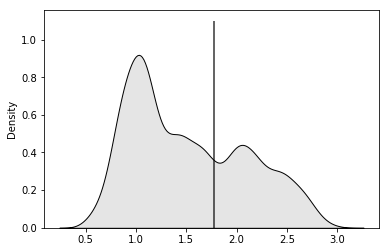

In [142]:
sns.kdeplot([q_sup - q_inf for q_inf, q_sup in quantis], alpha=0.1, shade=True, color='k')
plt.vlines(quantile_sup -quantile_inf , 0, 1.1, alpha=0.8)
plt.show()

## Cuidados

### Compromisso entre métricas de **estabilidade** e **performance**.

Se mudarmos o random_state do nosso modelo, será exemplos proxímos ficam distantes?


In [96]:
model_estab1 = RandomForestRegressor(random_state=1, max_depth=5).fit(X_train_house, y_train_house)

leaf_estab1 = model_estab1.apply(X_train_house)

nn_estab1 = NearestNeighbors(metric='hamming')
nn_estab1.fit(leaf_estab1)
dist_estab1, neig_estab1 = nn_estab1.kneighbors(leaf_estab1, n_neighbors=10)

In [97]:
model_estab2 = RandomForestRegressor(random_state=2, max_depth=5).fit(X_train_house, y_train_house)

leaf_estab2 = model_estab2.apply(X_train_house)

nn_estab2 = NearestNeighbors(metric='hamming')
nn_estab2.fit(leaf_estab2)
dist_estab2, neig_estab2 = nn_estab2.kneighbors(leaf_estab2, n_neighbors=10)

In [98]:
neig_estab1[0], neig_estab2[0]

(array([3130,    0, 3037, 5710, 4083, 5288, 5976, 5657, 5272,  601],
       dtype=int64),
 array([   0, 3130, 4083, 5702, 5657, 5341, 5920, 5288, 5272, 6743],
       dtype=int64))

In [99]:
dist_estab1

array([[0.  , 0.  , 0.01, ..., 0.01, 0.01, 0.01],
       [0.  , 0.02, 0.02, ..., 0.06, 0.06, 0.07],
       [0.  , 0.  , 0.  , ..., 0.01, 0.01, 0.01],
       ...,
       [0.  , 0.  , 0.  , ..., 0.02, 0.02, 0.02],
       [0.  , 0.15, 0.19, ..., 0.28, 0.29, 0.31],
       [0.  , 0.  , 0.  , ..., 0.02, 0.04, 0.04]])

In [100]:
dist_estab1.mean(axis=1)

array([0.008, 0.038, 0.003, ..., 0.01 , 0.225, 0.012])

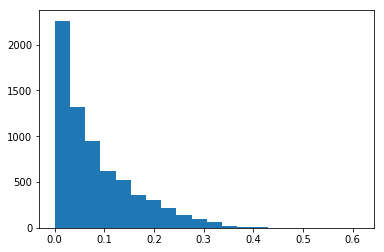

In [101]:
plt.hist(dist_estab1.mean(axis=1), bins=20)
plt.show()

In [102]:
set(neig_estab1[0]).intersection(set(neig_estab2[0]))

{0, 3130, 4083, 5272, 5288, 5657}

In [103]:
len(set(neig_estab1[0]).intersection(set(neig_estab2[0])))/len(set(neig_estab1[0]))

0.6

In [104]:
interseccoes = [len(set(vizinhos1).intersection(set(vizinhos2)))/len(set(vizinhos1)) for vizinhos1, vizinhos2 in zip(neig_estab1, neig_estab2)]

In [105]:
interseccoes

[0.6,
 0.8,
 0.8,
 0.5,
 0.7,
 0.8,
 0.6,
 0.8,
 0.9,
 0.8,
 0.7,
 0.7,
 0.6,
 0.9,
 0.9,
 0.7,
 0.9,
 0.4,
 0.9,
 0.4,
 0.7,
 0.7,
 0.6,
 0.2,
 0.9,
 0.9,
 0.8,
 0.3,
 0.8,
 0.5,
 0.9,
 0.9,
 0.8,
 0.6,
 0.6,
 0.8,
 0.6,
 0.7,
 0.5,
 0.7,
 0.8,
 0.9,
 0.8,
 1.0,
 0.5,
 0.6,
 0.6,
 0.9,
 0.7,
 0.8,
 0.4,
 0.7,
 0.2,
 0.6,
 0.8,
 0.7,
 0.3,
 0.8,
 0.7,
 0.4,
 0.8,
 0.9,
 0.8,
 0.7,
 0.9,
 0.6,
 0.2,
 0.6,
 0.7,
 0.8,
 0.8,
 0.4,
 0.8,
 0.9,
 0.8,
 0.8,
 0.9,
 0.8,
 0.4,
 0.6,
 0.7,
 0.5,
 0.4,
 0.8,
 0.9,
 0.3,
 0.9,
 0.7,
 0.2,
 0.8,
 0.8,
 0.8,
 0.7,
 0.9,
 0.3,
 0.3,
 0.6,
 0.7,
 0.8,
 0.9,
 0.6,
 0.8,
 0.8,
 0.6,
 0.8,
 0.7,
 0.3,
 0.9,
 0.3,
 0.9,
 0.7,
 0.7,
 0.4,
 0.5,
 0.9,
 0.5,
 0.7,
 0.7,
 0.5,
 1.0,
 0.8,
 0.4,
 0.6,
 0.9,
 0.5,
 0.8,
 0.6,
 0.3,
 0.3,
 0.8,
 0.9,
 0.8,
 1.0,
 0.9,
 0.9,
 0.6,
 0.8,
 0.7,
 0.9,
 0.7,
 0.7,
 0.6,
 0.7,
 0.6,
 0.7,
 0.9,
 0.4,
 0.4,
 0.9,
 0.6,
 0.8,
 0.8,
 0.5,
 0.7,
 0.8,
 0.5,
 0.8,
 0.7,
 0.7,
 0.8,
 1.0,
 0.8,
 0.6,
 0.8,
 0.8,
 0.8,
 0.9

In [106]:
# média de mesmos vizinhos mudando random_state
np.mean(interseccoes)

0.675625

In [107]:
# média das distancias médias
dist_estab1.mean(axis=1).mean()

0.08217107558139534

In [108]:
# quantos exemplos tem todos os vizinhos com uma distancia 0 dele
(dist_estab1.mean(axis=1)==0).mean()

0.06468023255813954

No seu tunning, essa estabilidade tem que ser levada em conta. Não só as métricas de otimização usuais do modelo.

In [109]:
from itertools import product
from sklearn.metrics import r2_score

dic = {'max_depth':[],
       'n_estimators':[],
       'r2':[],
       'estab':[]
      }

for max_depth, n_estimators in tqdm(product([2,10, None],[50,100,200])):
    neighs = []
    for random_state in [42, 666]:
        rfr_grid = (RandomForestRegressor(random_state=random_state, 
                                         max_depth = max_depth, n_estimators=n_estimators)
                    .fit(X_train_house, y_train_house)
                   )

        leaf_grip = rfr_grid.apply(X_cal_house)
        nn_grid = NearestNeighbors(metric='hamming')
        nn_grid.fit(leaf_grip)
        dist_grid, neig_grid = nn_grid.kneighbors(leaf_grip, n_neighbors=10)
        
        neighs.append(neig_grid)
        
    inter_grid = [len(set(vizinhos1).intersection(set(vizinhos2)))/len(set(vizinhos1)) for vizinhos1, vizinhos2 in zip(neighs[0], neighs[1])]
    
    dic['max_depth'].append(max_depth)
    dic['n_estimators'].append(n_estimators)
    dic['r2'].append(r2_score(y_cal_house, rfr_grid.predict(X_cal_house)))
    dic['estab'].append(np.mean(inter_grid))

9it [03:05, 25.41s/it]


In [110]:
pd.DataFrame(dic)

,max_depth,n_estimators,r2,estab
0,2.0,50,0.464890,0.049971
1,2.0,100,0.464976,0.125843
2,2.0,200,0.464432,0.112340
3,10.0,50,0.762889,0.689346
4,10.0,100,0.762190,0.766105
5,10.0,200,0.762693,0.828895
6,NaN,50,0.778068,0.594898
7,NaN,100,0.778923,0.694709
8,NaN,200,0.779839,0.777573
